# **CASE STUDY ASSIGNMENT**
**File:**

dataset.csv(Attached)
  Column1 has the dates 
  Column2 has the number of sales a bakery does on a given day.

**Goal:** 

To create an ML model for prediction of sales for N days in the future.

**Note:** 
- Create a design document with the appropriate sections.
- Choose the model most appropriate. Use at least 2 models and state why you have chosen one over the other.
- Use the right benchmarks and tabulate results.
- Be able to explain the flow with a system diagram.
- Show validation of the model trained.
- Can use any library ( Python)
- Create a test case document for QA. ( This will include the base cases of different ways a developer has to test his/her work)
- Submission to be done in the form of a python script which will take N as the argument. N= No of days in the future to make the prediction. Below is a sample output for passing the value of N as 6.
 

  ```
  Sample Output of the Assignment:
  DATE                          SALES
  3/26/19                       44
  3/27/19                       55
  3/28/19                       66
  3/29/19                       77
  3/30/19                       88
  3/31/19                       99
  ```
## Steps Involved:

1. Loading Dataset
2. Data Preprocessing
3. Perfroming time-series decomposition
4. Performing Train-Test Split
5. Model building
6. Finalizing model


# **1. Loading Dataset**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings

%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Recruitment Drive/GEMBO/dataset.csv')
df['DATE'] = pd.to_datetime(df['DATE'])
df.head()

,DATE,SALES
0,2018-09-30,39
1,2018-10-01,25
2,2018-10-02,48
3,2018-10-03,32
4,2018-10-04,87


# **2. Data Preprocessing** 

## **2.1. Dealing with missing values**

In [3]:
# Based on provided dataframe below are the start_date and end_date
START_DATE = '2018-09-30'
END_DATE = '2019-03-25'
# Mapping sales figure to above Date range to check for missing values
dates = pd.DataFrame(pd.date_range(start=START_DATE, end=END_DATE),columns=['DATE'])
df_main = dates.merge(df,how="left")
df_main = df_main.set_index('DATE')
df_main.head()

,SALES
DATE,
2018-09-30,39.0
2018-10-01,25.0
2018-10-02,48.0
2018-10-03,32.0
2018-10-04,87.0


In [4]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 177 entries, 2018-09-30 to 2019-03-25
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SALES   173 non-null    float64
dtypes: float64(1)
memory usage: 2.8 KB


Below table shows that there are **4 missing records** present in sales data.

In [5]:
df_main.isnull().sum()

SALES    4
dtype: int64

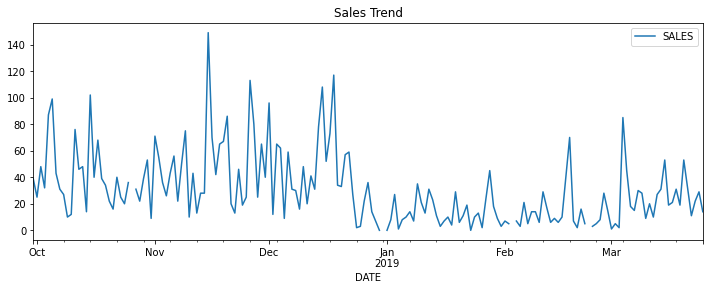

In [6]:
df_main.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Sales Trend')
plt.show(block=False)

Treating missing values using **linear interpolation.**

In [7]:
df_main['SALES'].interpolate(method='linear',inplace=True)

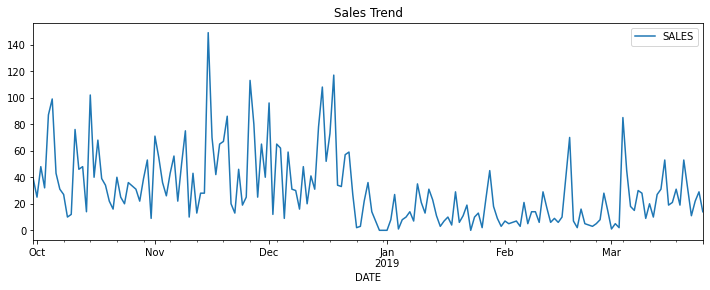

In [8]:
df_main.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Sales Trend')
plt.show(block=False)

## **2.2. Outliers Treatment**

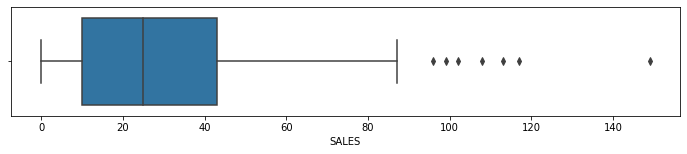

In [9]:
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=df['SALES'])

# **3. Perfroming time-series decomposition**

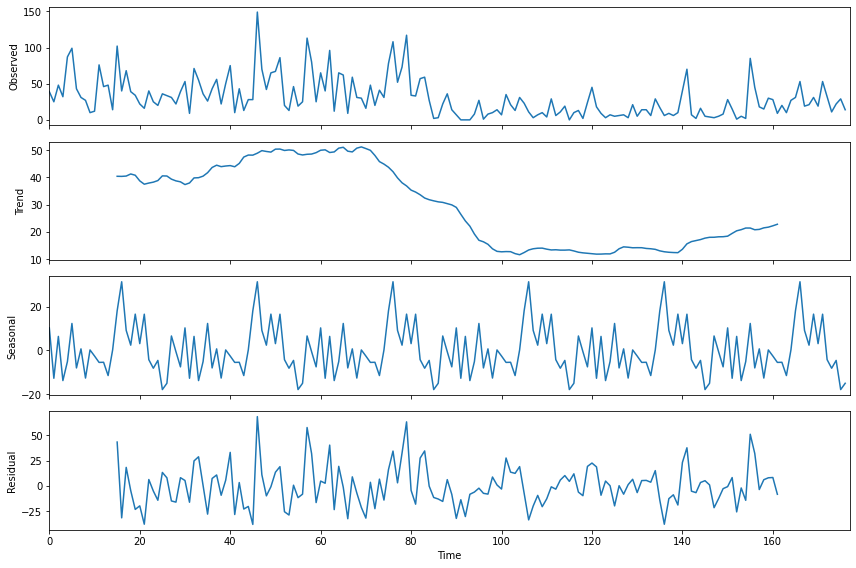

In [10]:
# https://stackoverflow.com/questions/40794282/value-error-in-python-statsmodels-tsa-seasonal
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 12, 8
decomposition = sm.tsa.seasonal_decompose(df_main.SALES.values,freq=30) # additive seasonal index
fig = decomposition.plot()
plt.show()

**Inferences**: 

- Above decomposition suggests that sales initially had a downward trend but its starting to pick-up again in the month of March.

- Dataset also seems to follow a monthly seasonal pattern.
- Residual doesn't shows any visible patterns, therefore we can conclude that given sequence is additive in nature.

# **4. Performing Train-Test Split**

In [11]:
df_main.shape

(177, 1)

In [12]:
80*177//100

141

In [13]:
# Performing 80:20 split
train_len = 141
train = df_main[0:train_len] # first 141 days as training set
test = df_main[train_len:] # last 36 days as test set

# **5. Model building**

## **5.1. Triple Exponential Smoothing or Holt Winter's smoothening**

refrence : https://towardsdatascience.com/holt-winters-exponential-smoothing-d703072c0572

Using Holt Winter's Smoothening model from statsmodels API. 

In [14]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# Training Triple ES model
model_1 = ExponentialSmoothing(np.asarray(train['SALES']) ,seasonal_periods=31 ,trend='add', seasonal='add')
model_fit_1 = model_1.fit(optimized=True)

In [15]:
# Generating forecast for test set
y_hat_hwa = test.copy()
y_hat_hwa['hw_forecast'] = model_fit_1.forecast(len(test))

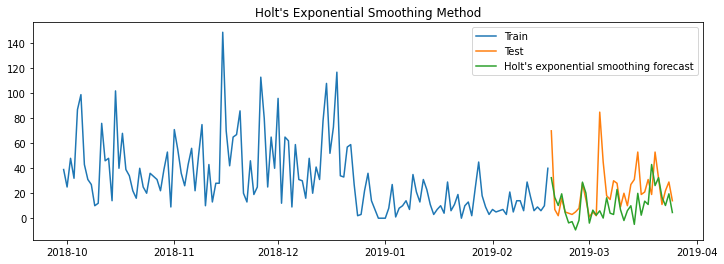

In [16]:
plt.figure(figsize=(12,4))
plt.plot( train['SALES'], label='Train')
plt.plot(test['SALES'], label='Test')
plt.plot(y_hat_hwa['hw_forecast'], label='Holt\'s exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Holt\'s Exponential Smoothing Method')
plt.show()

In [17]:
# Model Evaluation
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['SALES'], y_hat_hwa['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['SALES']-y_hat_hwa['hw_forecast'])/test['SALES'])*100,2)

tempResults1 = pd.DataFrame({'Method':['Holt Winters\' additive method'], 'RMSE': [rmse],'MAPE': [mape] })
tempResults1

,Method,RMSE,MAPE
0,Holt Winters' additive method,21.55,93.81


## **5.2. Seasonal auto regressive integrated moving average (SARIMA)**

### **5.2.1 Stationary Test**

**Augmented Dickey-Fuller (ADF) test**

In [18]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(df_main['SALES'])
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

ADF Statistic: -3.725499
p-value: 0.003768


Above p-value suggests that dataset is `Stationary` in nature. Therefore, there is no need to perform data transformation.

### **5.2.2. Checking ACF and PACF plot**

**ACF plot**

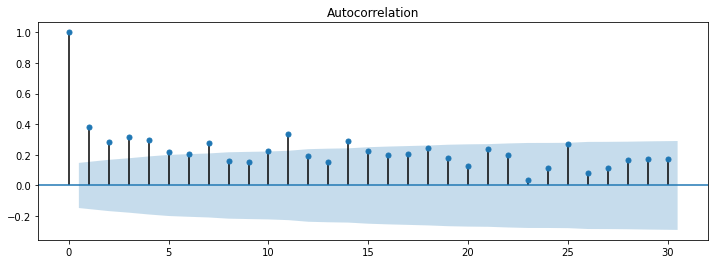

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(12,4))
plot_acf(df_main, ax=plt.gca(), lags = 30)
plt.show() 

Above ACF plot indicates that **q = 7** seems to be and optimal value.

**PACF plot**

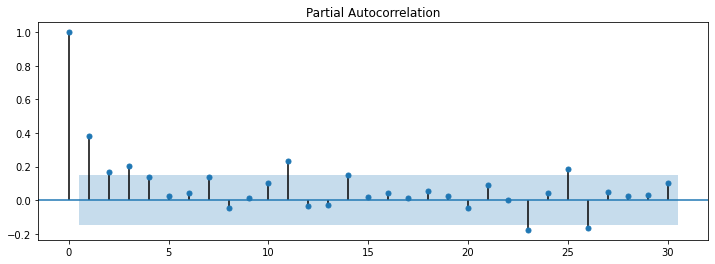

In [20]:
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(12,4))
plot_pacf(df_main, ax=plt.gca(), lags = 30)
plt.show()

Based on PACF plot **p=4** seems to be an optimal value.

### **5.2.3. Model Training & Testing**

**Model parameters**
- p = 4 : Based on PACF plot
- s = 0 : Since our data is stationary
- q = 7 : Based on ACF plot
- D = 31 : Seasonality

In [48]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Training SARIMAX model
model_2 = SARIMAX(df_main, order=(4, 0, 7), seasonal_order=(1, 0, 1, 31)) 
model_fit_2 = model_2.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [49]:
# Generating forecast for test set
y_hat_sarima = df_main.copy()
y_hat_sarima['sarima_forecast'] = model_fit_2.predict(df_main.index.min(), df_main.index.max())

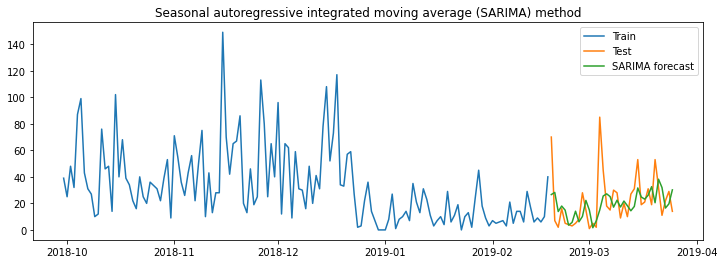

In [50]:
plt.figure(figsize=(12,4))
plt.plot(train['SALES'], label='Train')
plt.plot(test['SALES'], label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test.index.min():], label='SARIMA forecast')
plt.legend(loc='best')
plt.title('Seasonal autoregressive integrated moving average (SARIMA) method')
plt.show()

In [51]:
# Model Evaluation
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['SALES'], y_hat_sarima['sarima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['SALES']-y_hat_sarima['sarima_forecast'][test.index.min():])/test['SALES'])*100,2)

tempResults2 = pd.DataFrame({'Method':['SARIMAX'], 'RMSE': [rmse],'MAPE': [mape] })
tempResults2

,Method,RMSE,MAPE
0,SARIMAX,18.28,124.44


# **6. Finalizing model**

In [53]:
Results = pd.concat([tempResults1,tempResults2])

In [54]:
Results

,Method,RMSE,MAPE
0,Holt Winters' additive method,21.55,93.81
0,SARIMAX,18.28,124.44


Based on above results `Holt Winter's additive method` seems to provide more consistent results. Thus, eventhough SARMIX have better RMSE i have considered Holt Winter's additive method as the final model.